# A.3题 最佳机器排班表问题

### 问题重述

工厂是否可以通过不购买新设备而是改变前述机床设备整修方案来提高总利润？请构造一个机床设备整修计划数学模型，使原来计划整修的机床设备在这六个月中都得到整修，而使利润尽可能大。

### 问题分析

本问题即<font size=5>能否通过更改机器的排班表，实现利润的更大化</font>。<br>
由于不同月的零件的可销售额不同，因此不同的机器排班表是有意义的。<br>

选择机器学习手段训练模型对<font size=5>不同的月的机器的数量与最终最大利润的关系</font>进行训练<br>
然后用训练好的模型对所有可能排版表进行预测，找出其中最大化利润的排班表

### 效率分析

由后续代码可知，可能的排班表约为 $ 10^7$ 种。<br>
虽然使用枚举法可以准确得知最佳方案，但是时间代价是无法接受的。<br>
利用训练好的模型进行预测可以将时间压制到小时级，属于可接受范围。<br>

### 问题实现

#### 构造所有可能的机器排班表

<font size=6 color=red>如果./distributed_storage中有Machine_*.pkl文件，则不需要运行本部分代码</font>

Machine:   假设不需要维修的机器排班表<br>
FIX:       需要维修的机器总数<br>

In [1]:
import copy
Machine=[[6,3,4,2,1] for _ in range(6)]
FIX=[3,2,2,1,1]

构造所有满足可能情况

In [2]:
def genter(target: int, temp: list[int],answer):
    if sum(temp) == target:
        answer.append(temp.copy())  # 添加一个副本到答案列表中，避免修改已存在的列表
    else:
            for i in range(len(temp)):
                new_temp = temp.copy()  # 创建一个新的列表，避免修改原始列表
                new_temp[i] += 1
                genter(target, new_temp,answer)
def List_Maker(n:int):
    answer1=[]
    genter(n,[0,0,0,0,0,0],answer1)
    return answer1

In [3]:
FIX_PROB=[]
for i in FIX:
    FIX_PROB.append(List_Maker(i))

In [4]:
def transpose_list(matrix):
    if not matrix:
        return []
    
    rows = len(matrix)
    cols = len(matrix[0])
    
    transposed_matrix = []
    for j in range(cols):
        transposed_row = []
        for i in range(rows):
            transposed_row.append(matrix[i][j])
        transposed_matrix.append(transposed_row)
    
    return transposed_matrix
def matrix_subtraction(matrix1, matrix2):
    rows = len(matrix1)
    cols = len(matrix1[0])
    
    result = []
    for i in range(rows):
        row = []
        for j in range(cols):
            row.append(matrix1[i][j] - matrix2[i][j])
        result.append(row)
    
    return result

In [5]:
FIX_ALL_ANSWER=[]
for i in FIX_PROB[0]:
    for j in FIX_PROB[1]:
        for k in FIX_PROB[2]:
            for l in FIX_PROB[3]:
                for m in FIX_PROB[4]:
                    TEMP=copy.deepcopy([])
                    TEMP.append(i)
                    TEMP.append(j)
                    TEMP.append(k)
                    TEMP.append(l)
                    TEMP.append(m)
                    temp1=matrix_subtraction(transpose_list(Machine),TEMP)
                    FIX_ALL_ANSWER.append(temp1)

In [6]:
print(f"可能的情况总数为：",len(FIX_ALL_ANSWER))

可能的情况总数为： 10077696


将计算结果保存到本地

In [7]:
import os
import pickle
import math

def save_machines_chunked(output_dir, data, chunk_size=20000):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # 计算总块数
    total_chunks = math.ceil(len(data) / chunk_size)
    # 分块并保存数据
    for i in range(total_chunks):
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size
        chunk = data[start_idx:end_idx]
        filename = os.path.join(output_dir, f"Machine_{i}.pkl")
        with open(filename, 'wb') as f:
            pickle.dump(chunk, f)

# 假设FIX_ALL_ANSWER是您要保存的数据列表
output_directory = "distributed_storage"
save_machines_chunked(output_directory, FIX_ALL_ANSWER)


#### 数据准备

<font size =6 color=red> 如果csvdata文件夹下存在预处理完的csv文件，则可视为已完成数据准备</font>

##### 将原始数据读入内存

In [1]:
import os
import pickle
import numpy as np

def load_all_chunks(input_dir):
    all_chunks = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.pkl'):
            filepath = os.path.join(input_dir, filename)
            with open(filepath, 'rb') as f:
                chunk = pickle.load(f)
            all_chunks.append(chunk)
    merged_data = np.concatenate(all_chunks, axis=0)
    return merged_data
input_directory = "distributed_storage"
FIX_ALL_ANSWER = load_all_chunks(input_directory)


In [2]:
print(FIX_ALL_ANSWER[0])

[[3 6 6 6 6 6]
 [1 3 3 3 3 3]
 [2 4 4 4 4 4]
 [1 2 2 2 2 2]
 [0 1 1 1 1 1]]


##### 数据预处理

随机计算一部分可能的情况，为模型准备数据

多次随机抽样1000次可能的情况并把计算结果本地化存储

In [3]:
import random
import csv
from core import LinearProblem
def transpose_list(matrix):
    if not matrix:
        return []
    
    rows = len(matrix)
    cols = len(matrix[0])
    
    transposed_matrix = []
    for j in range(cols):
        transposed_row = []
        for i in range(rows):
            transposed_row.append(matrix[i][j])
        transposed_matrix.append(transposed_row)
    
    return transposed_matrix
def process_samples(i,l):
    problem=LinearProblem.LinearCore()
    for j in range(i,l):
        # 创建一个空的结果列表
        results = []
        # 随机抽样 1000 次
        for o in range(1000):
            # 随机选择一个样本
            sample = random.choice(FIX_ALL_ANSWER)
            problem.reset_machine(transpose_list(sample.tolist()))
            # 对样本执行 SOLVE 函数
            result = problem.solveP()
            # 将样本和结果保存到结果列表中
            results.append((sample.tolist(), result))
            print(f"the number is {o}\n")
        # 将结果保存到 CSV 文件中
        with open(f'csvdata\sample_results_{j}.csv', 'w', newline='') as csvfile:
            fieldnames = ['sample', 'result']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            for sample, result in results:
                writer.writerow({'sample': sample, 'result': result})
        print(f"第{j}次完成")

process_samples(165,300)


C:\Users\12780\AppData\Roaming\Python\Python39\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

th

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number i

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number i

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number i

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number i

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number i

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number i

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the n

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number i

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number i

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number i

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number i

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number i

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number i

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 1

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number i

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第171次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number i

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number i

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number i

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number i

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number i

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number i

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number i

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number i

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number i

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number i

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number i

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number i

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number i

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number i

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number i

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number i

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number i

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number i

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number i

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number i

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number i

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number i

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第181次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number 

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number i

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number i

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number i

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number i

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number i

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number i

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number i

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number i

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number i

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number i

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number i

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number i

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number i

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number i

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number i

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number i

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number i

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number i

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number i

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number i

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第191次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number i

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number i

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number i

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number i

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number i

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number i

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number i

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number i

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number i

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number i

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number i

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number i

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the 

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number i

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第198次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6


the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number i

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number i

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number i

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number i

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number i

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number i

the number is 999

第201次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number 

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number i

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number i

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number i

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number i

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number i

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number i

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number i

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number i

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number i

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number i

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number i

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number i

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145



the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number i

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第208次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the n

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number i

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number i

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number i

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number i

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number i

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number i

the number is 999

第211次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number 

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number i

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number i

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number i

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number i

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number i

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number i

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the numbe

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number i

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number i

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number i

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number i

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number i

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number i

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145



the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number i

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第218次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the num

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number i

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number i

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number i

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number i

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number i

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number i

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58


the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number i

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number i

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number i

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number i

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number i

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number i

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the nu

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number i

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number i

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number i

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number i

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number i

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number i

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 1

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number i

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第228次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number i

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number i

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number i

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number i

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number i

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number i

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 6

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number i

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number i

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number i

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number i

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number i

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number i

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the 

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number i

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number i

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number i

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number i

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number i

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number i

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number i

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number i

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第238次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number i

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number i

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number i

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number i

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number i

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number i

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number i

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number i

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number i

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number i

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number i

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number i

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number i

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number i

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number i

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number i

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number i

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number i

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number i

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number i

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number i

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第248次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

th

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number i

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number i

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number i

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number i

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number i

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number i

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number i

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number i

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number i

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number i

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number i

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number i

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number i

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number i

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number i

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number i

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number i

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number i

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number i

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number i

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第258次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

th

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number i

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number i

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number i

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number i

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number i

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number i

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number i

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number i

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number i

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number i

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number i

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number i

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 1

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number i

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number i

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number i

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number i

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number i

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number i

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number i

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number i

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第268次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

th

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number i

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number i

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number i

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number i

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number i

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number i

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number i

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number i

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number i

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number i

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number i

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number i

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the nu

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number i

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number i

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number i

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number i

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number i

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number i

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number i

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number i

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第278次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number i

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number i

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number i

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number i

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number i

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number i

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number i

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number i

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number i

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number i

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number i

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number i

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

t

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number i

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number i

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number i

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number i

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number i

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number i

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number i

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number i

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第288次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number i

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number i

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number is 312

the number is 313

the number is 314

the number is 315

the number is 316

the number is 317

the number is 318

the number is 319

the number is 320

the number is 321

the number is 322

the number is 323

the number is 324

the number is 325

the number is 326

the number is 327

the number is 328

the number is 329

the number is 330

the number is 331

the number is 332

the number is 333

the number is 334

the number is 335

the number is 336

the number is 337

the number is 338

the number is 339

the number is 340

the number is 341

the number is 342

the number is 343

the number is 344

the number i

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number is 744

the number is 745

the number is 746

the number is 747

the number is 748

the number is 749

the number is 750

the number is 751

the number is 752

the number is 753

the number is 754

the number is 755

the number is 756

the number is 757

the number is 758

the number is 759

the number is 760

the number is 761

the number is 762

the number is 763

the number is 764

the number is 765

the number is 766

the number is 767

the number is 768

the number is 769

the number is 770

the number is 771

the number is 772

the number is 773

the number is 774

the number is 775

the number is 776

the number i

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number is 184

the number is 185

the number is 186

the number is 187

the number is 188

the number is 189

the number is 190

the number is 191

the number is 192

the number is 193

the number is 194

the number is 195

the number is 196

the number is 197

the number is 198

the number is 199

the number is 200

the number is 201

the number is 202

the number is 203

the number is 204

the number is 205

the number is 206

the number is 207

the number is 208

the number is 209

the number is 210

the number is 211

the number is 212

the number is 213

the number is 214

the number is 215

the number i

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number is 616

the number is 617

the number is 618

the number is 619

the number is 620

the number is 621

the number is 622

the number is 623

the number is 624

the number is 625

the number is 626

the number is 627

the number is 628

the number is 629

the number is 630

the number is 631

the number is 632

the number is 633

the number is 634

the number is 635

the number is 636

the number is 637

the number is 638

the number is 639

the number is 640

the number is 641

the number is 642

the number is 643

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number i

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the number is 51

the number is 52

the number is 53

the number is 54

the number is 55

the number is 56

the number is 57

the number is 58

the number is 59

the number is 60

the number is 61

the number is 62

the number is 63

the number is 64

the number is 65

the number is 66

the number is 67

the number is 68

the number is 69

the number is 70

the number is 71

the number is 72

the number is 73

the number is 74

the number is 75

the number is 76

the number is 77

the number is 78

the number is 79

the number is 80

the number is 81

the number is 82

the number is 83

the number is 84

the number is 85

the number

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number is 486

the number is 487

the number is 488

the number is 489

the number is 490

the number is 491

the number is 492

the number is 493

the number is 494

the number is 495

the number is 496

the number is 497

the number is 498

the number is 499

the number is 500

the number is 501

the number is 502

the number is 503

the number is 504

the number is 505

the number is 506

the number is 507

the number is 508

the number is 509

the number is 510

the number is 511

the number is 512

the number is 513

the number is 514

the number is 515

the number is 516

the number is 517

the number is 518

the number is 519

the number i

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number is 919

the number is 920

the number is 921

the number is 922

the number is 923

the number is 924

the number is 925

the number is 926

the number is 927

the number is 928

the number is 929

the number is 930

the number is 931

the number is 932

the number is 933

the number is 934

the number is 935

the number is 936

the number is 937

the number is 938

the number is 939

the number is 940

the number is 941

the number is 942

the number is 943

the number is 944

the number is 945

the number is 946

the number is 947

the number is 948

the number is 949

the number is 950

the number is 951

the number is 952

the number is 953

the number is 954

the number i

the number is 343

the number is 344

the number is 345

the number is 346

the number is 347

the number is 348

the number is 349

the number is 350

the number is 351

the number is 352

the number is 353

the number is 354

the number is 355

the number is 356

the number is 357

the number is 358

the number is 359

the number is 360

the number is 361

the number is 362

the number is 363

the number is 364

the number is 365

the number is 366

the number is 367

the number is 368

the number is 369

the number is 370

the number is 371

the number is 372

the number is 373

the number is 374

the number is 375

the number is 376

the number is 377

the number is 378

the number is 379

the number is 380

the number is 381

the number is 382

the number is 383

the number is 384

the number is 385

the number is 386

the number is 387

the number is 388

the number is 389

the number is 390

the number is 391

the number is 392

the number is 393

the number is 394

the number i

the number is 775

the number is 776

the number is 777

the number is 778

the number is 779

the number is 780

the number is 781

the number is 782

the number is 783

the number is 784

the number is 785

the number is 786

the number is 787

the number is 788

the number is 789

the number is 790

the number is 791

the number is 792

the number is 793

the number is 794

the number is 795

the number is 796

the number is 797

the number is 798

the number is 799

the number is 800

the number is 801

the number is 802

the number is 803

the number is 804

the number is 805

the number is 806

the number is 807

the number is 808

the number is 809

the number is 810

the number is 811

the number is 812

the number is 813

the number is 814

the number is 815

the number is 816

the number is 817

the number is 818

the number is 819

the number is 820

the number is 821

the number is 822

the number is 823

the number is 824

the number is 825

the number is 826

the number i

the number is 212

the number is 213

the number is 214

the number is 215

the number is 216

the number is 217

the number is 218

the number is 219

the number is 220

the number is 221

the number is 222

the number is 223

the number is 224

the number is 225

the number is 226

the number is 227

the number is 228

the number is 229

the number is 230

the number is 231

the number is 232

the number is 233

the number is 234

the number is 235

the number is 236

the number is 237

the number is 238

the number is 239

the number is 240

the number is 241

the number is 242

the number is 243

the number is 244

the number is 245

the number is 246

the number is 247

the number is 248

the number is 249

the number is 250

the number is 251

the number is 252

the number is 253

the number is 254

the number is 255

the number is 256

the number is 257

the number is 258

the number is 259

the number is 260

the number is 261

the number is 262

the number is 263

the number i

the number is 644

the number is 645

the number is 646

the number is 647

the number is 648

the number is 649

the number is 650

the number is 651

the number is 652

the number is 653

the number is 654

the number is 655

the number is 656

the number is 657

the number is 658

the number is 659

the number is 660

the number is 661

the number is 662

the number is 663

the number is 664

the number is 665

the number is 666

the number is 667

the number is 668

the number is 669

the number is 670

the number is 671

the number is 672

the number is 673

the number is 674

the number is 675

the number is 676

the number is 677

the number is 678

the number is 679

the number is 680

the number is 681

the number is 682

the number is 683

the number is 684

the number is 685

the number is 686

the number is 687

the number is 688

the number is 689

the number is 690

the number is 691

the number is 692

the number is 693

the number is 694

the number is 695

the number i

the number is 83

the number is 84

the number is 85

the number is 86

the number is 87

the number is 88

the number is 89

the number is 90

the number is 91

the number is 92

the number is 93

the number is 94

the number is 95

the number is 96

the number is 97

the number is 98

the number is 99

the number is 100

the number is 101

the number is 102

the number is 103

the number is 104

the number is 105

the number is 106

the number is 107

the number is 108

the number is 109

the number is 110

the number is 111

the number is 112

the number is 113

the number is 114

the number is 115

the number is 116

the number is 117

the number is 118

the number is 119

the number is 120

the number is 121

the number is 122

the number is 123

the number is 124

the number is 125

the number is 126

the number is 127

the number is 128

the number is 129

the number is 130

the number is 131

the number is 132

the number is 133

the number is 134

the number is 135

the number

the number is 518

the number is 519

the number is 520

the number is 521

the number is 522

the number is 523

the number is 524

the number is 525

the number is 526

the number is 527

the number is 528

the number is 529

the number is 530

the number is 531

the number is 532

the number is 533

the number is 534

the number is 535

the number is 536

the number is 537

the number is 538

the number is 539

the number is 540

the number is 541

the number is 542

the number is 543

the number is 544

the number is 545

the number is 546

the number is 547

the number is 548

the number is 549

the number is 550

the number is 551

the number is 552

the number is 553

the number is 554

the number is 555

the number is 556

the number is 557

the number is 558

the number is 559

the number is 560

the number is 561

the number is 562

the number is 563

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number i

the number is 951

the number is 952

the number is 953

the number is 954

the number is 955

the number is 956

the number is 957

the number is 958

the number is 959

the number is 960

the number is 961

the number is 962

the number is 963

the number is 964

the number is 965

the number is 966

the number is 967

the number is 968

the number is 969

the number is 970

the number is 971

the number is 972

the number is 973

the number is 974

the number is 975

the number is 976

the number is 977

the number is 978

the number is 979

the number is 980

the number is 981

the number is 982

the number is 983

the number is 984

the number is 985

the number is 986

the number is 987

the number is 988

the number is 989

the number is 990

the number is 991

the number is 992

the number is 993

the number is 994

the number is 995

the number is 996

the number is 997

the number is 998

the number is 999

第295次完成
the number is 0

the number is 1

the number is 2

the number

the number is 391

the number is 392

the number is 393

the number is 394

the number is 395

the number is 396

the number is 397

the number is 398

the number is 399

the number is 400

the number is 401

the number is 402

the number is 403

the number is 404

the number is 405

the number is 406

the number is 407

the number is 408

the number is 409

the number is 410

the number is 411

the number is 412

the number is 413

the number is 414

the number is 415

the number is 416

the number is 417

the number is 418

the number is 419

the number is 420

the number is 421

the number is 422

the number is 423

the number is 424

the number is 425

the number is 426

the number is 427

the number is 428

the number is 429

the number is 430

the number is 431

the number is 432

the number is 433

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number i

the number is 823

the number is 824

the number is 825

the number is 826

the number is 827

the number is 828

the number is 829

the number is 830

the number is 831

the number is 832

the number is 833

the number is 834

the number is 835

the number is 836

the number is 837

the number is 838

the number is 839

the number is 840

the number is 841

the number is 842

the number is 843

the number is 844

the number is 845

the number is 846

the number is 847

the number is 848

the number is 849

the number is 850

the number is 851

the number is 852

the number is 853

the number is 854

the number is 855

the number is 856

the number is 857

the number is 858

the number is 859

the number is 860

the number is 861

the number is 862

the number is 863

the number is 864

the number is 865

the number is 866

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number i

the number is 260

the number is 261

the number is 262

the number is 263

the number is 264

the number is 265

the number is 266

the number is 267

the number is 268

the number is 269

the number is 270

the number is 271

the number is 272

the number is 273

the number is 274

the number is 275

the number is 276

the number is 277

the number is 278

the number is 279

the number is 280

the number is 281

the number is 282

the number is 283

the number is 284

the number is 285

the number is 286

the number is 287

the number is 288

the number is 289

the number is 290

the number is 291

the number is 292

the number is 293

the number is 294

the number is 295

the number is 296

the number is 297

the number is 298

the number is 299

the number is 300

the number is 301

the number is 302

the number is 303

the number is 304

the number is 305

the number is 306

the number is 307

the number is 308

the number is 309

the number is 310

the number is 311

the number i

the number is 692

the number is 693

the number is 694

the number is 695

the number is 696

the number is 697

the number is 698

the number is 699

the number is 700

the number is 701

the number is 702

the number is 703

the number is 704

the number is 705

the number is 706

the number is 707

the number is 708

the number is 709

the number is 710

the number is 711

the number is 712

the number is 713

the number is 714

the number is 715

the number is 716

the number is 717

the number is 718

the number is 719

the number is 720

the number is 721

the number is 722

the number is 723

the number is 724

the number is 725

the number is 726

the number is 727

the number is 728

the number is 729

the number is 730

the number is 731

the number is 732

the number is 733

the number is 734

the number is 735

the number is 736

the number is 737

the number is 738

the number is 739

the number is 740

the number is 741

the number is 742

the number is 743

the number i

the number is 132

the number is 133

the number is 134

the number is 135

the number is 136

the number is 137

the number is 138

the number is 139

the number is 140

the number is 141

the number is 142

the number is 143

the number is 144

the number is 145

the number is 146

the number is 147

the number is 148

the number is 149

the number is 150

the number is 151

the number is 152

the number is 153

the number is 154

the number is 155

the number is 156

the number is 157

the number is 158

the number is 159

the number is 160

the number is 161

the number is 162

the number is 163

the number is 164

the number is 165

the number is 166

the number is 167

the number is 168

the number is 169

the number is 170

the number is 171

the number is 172

the number is 173

the number is 174

the number is 175

the number is 176

the number is 177

the number is 178

the number is 179

the number is 180

the number is 181

the number is 182

the number is 183

the number i

the number is 564

the number is 565

the number is 566

the number is 567

the number is 568

the number is 569

the number is 570

the number is 571

the number is 572

the number is 573

the number is 574

the number is 575

the number is 576

the number is 577

the number is 578

the number is 579

the number is 580

the number is 581

the number is 582

the number is 583

the number is 584

the number is 585

the number is 586

the number is 587

the number is 588

the number is 589

the number is 590

the number is 591

the number is 592

the number is 593

the number is 594

the number is 595

the number is 596

the number is 597

the number is 598

the number is 599

the number is 600

the number is 601

the number is 602

the number is 603

the number is 604

the number is 605

the number is 606

the number is 607

the number is 608

the number is 609

the number is 610

the number is 611

the number is 612

the number is 613

the number is 614

the number is 615

the number i

the number is 996

the number is 997

the number is 998

the number is 999

第298次完成
the number is 0

the number is 1

the number is 2

the number is 3

the number is 4

the number is 5

the number is 6

the number is 7

the number is 8

the number is 9

the number is 10

the number is 11

the number is 12

the number is 13

the number is 14

the number is 15

the number is 16

the number is 17

the number is 18

the number is 19

the number is 20

the number is 21

the number is 22

the number is 23

the number is 24

the number is 25

the number is 26

the number is 27

the number is 28

the number is 29

the number is 30

the number is 31

the number is 32

the number is 33

the number is 34

the number is 35

the number is 36

the number is 37

the number is 38

the number is 39

the number is 40

the number is 41

the number is 42

the number is 43

the number is 44

the number is 45

the number is 46

the number is 47

the number is 48

the number is 49

the number is 50

the numb

the number is 434

the number is 435

the number is 436

the number is 437

the number is 438

the number is 439

the number is 440

the number is 441

the number is 442

the number is 443

the number is 444

the number is 445

the number is 446

the number is 447

the number is 448

the number is 449

the number is 450

the number is 451

the number is 452

the number is 453

the number is 454

the number is 455

the number is 456

the number is 457

the number is 458

the number is 459

the number is 460

the number is 461

the number is 462

the number is 463

the number is 464

the number is 465

the number is 466

the number is 467

the number is 468

the number is 469

the number is 470

the number is 471

the number is 472

the number is 473

the number is 474

the number is 475

the number is 476

the number is 477

the number is 478

the number is 479

the number is 480

the number is 481

the number is 482

the number is 483

the number is 484

the number is 485

the number i

the number is 867

the number is 868

the number is 869

the number is 870

the number is 871

the number is 872

the number is 873

the number is 874

the number is 875

the number is 876

the number is 877

the number is 878

the number is 879

the number is 880

the number is 881

the number is 882

the number is 883

the number is 884

the number is 885

the number is 886

the number is 887

the number is 888

the number is 889

the number is 890

the number is 891

the number is 892

the number is 893

the number is 894

the number is 895

the number is 896

the number is 897

the number is 898

the number is 899

the number is 900

the number is 901

the number is 902

the number is 903

the number is 904

the number is 905

the number is 906

the number is 907

the number is 908

the number is 909

the number is 910

the number is 911

the number is 912

the number is 913

the number is 914

the number is 915

the number is 916

the number is 917

the number is 918

the number i

#### 模型训练

准备读入数据

In [4]:
def parse_to_float(input_string:str):
    # 去除字符串中的空格和方括号，然后按逗号分割得到列表
    data_list = input_string.replace('[', '').replace(']', '').split(',')
    # 将列表中的每个元素转换为 float 类型
    float_data = [float(item) for item in data_list]
    
    return float_data

将数据读入并划分为输入输出数据集

In [5]:
import numpy as np
import pandas as pd
csvDATA="csvdata\\"
def datareader(number,number1):
    x_data=np.array([])
    y_data=np.array([])
    for i in range(number,number1):
        filename=csvDATA+f"sample_results_{i}.csv"
        Data=pd.read_csv(filename)
        X = Data.iloc[:, 0].values.flatten()
        y = Data.iloc[:, 1].values
        x_data = np.concatenate((x_data, X))
        y_data = np.concatenate((y_data, y))
    return x_data,y_data
X,y=datareader(0,300)
x=[]
Y=[]
for i in X:
    x.append(parse_to_float(i))
for i in y:
    Y.append(float(i))
X=np.array(x)
y=np.array(Y)
# 随机生成一个相同的索引序列
indices = np.arange(len(X))
np.random.shuffle(indices)

# 使用相同的索引序列打乱两个数组
X = X[indices]
y = y[indices]

In [6]:
print(X[0])

[5. 6. 6. 5. 5. 6. 2. 2. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 1. 2. 2. 2. 2. 2.
 1. 0. 1. 1. 1. 1.]


##### 利用多种模型进行训练并比较效果

In [7]:
from sklearn.model_selection import train_test_split

# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


##### 决策树

每折交叉验证的评分: [0.99988092 0.99988706 0.99987166 0.9999081  0.99989331]
交叉验证评分的平均值: 0.9998882083823295
决策树模型性能评分: 0.999916391990226
特征重要性: [4.35943781e-02 2.86719339e-02 3.43238465e-02 7.41457188e-02
 8.27228950e-02 2.18279035e-02 3.36610168e-03 3.47396674e-04
 1.03710281e-07 3.66025641e-02 4.77352683e-05 1.33341177e-02
 3.16107943e-04 1.72665038e-04 9.10024398e-04 3.67246961e-09
 5.57762185e-06 5.28189591e-06 2.43331620e-07 4.24766842e-07
 3.61906264e-07 4.91056730e-07 4.16095091e-07 5.79038420e-07
 3.99379000e-03 2.47221216e-02 4.55124227e-02 1.75281936e-03
 3.33177421e-01 2.50444553e-01]


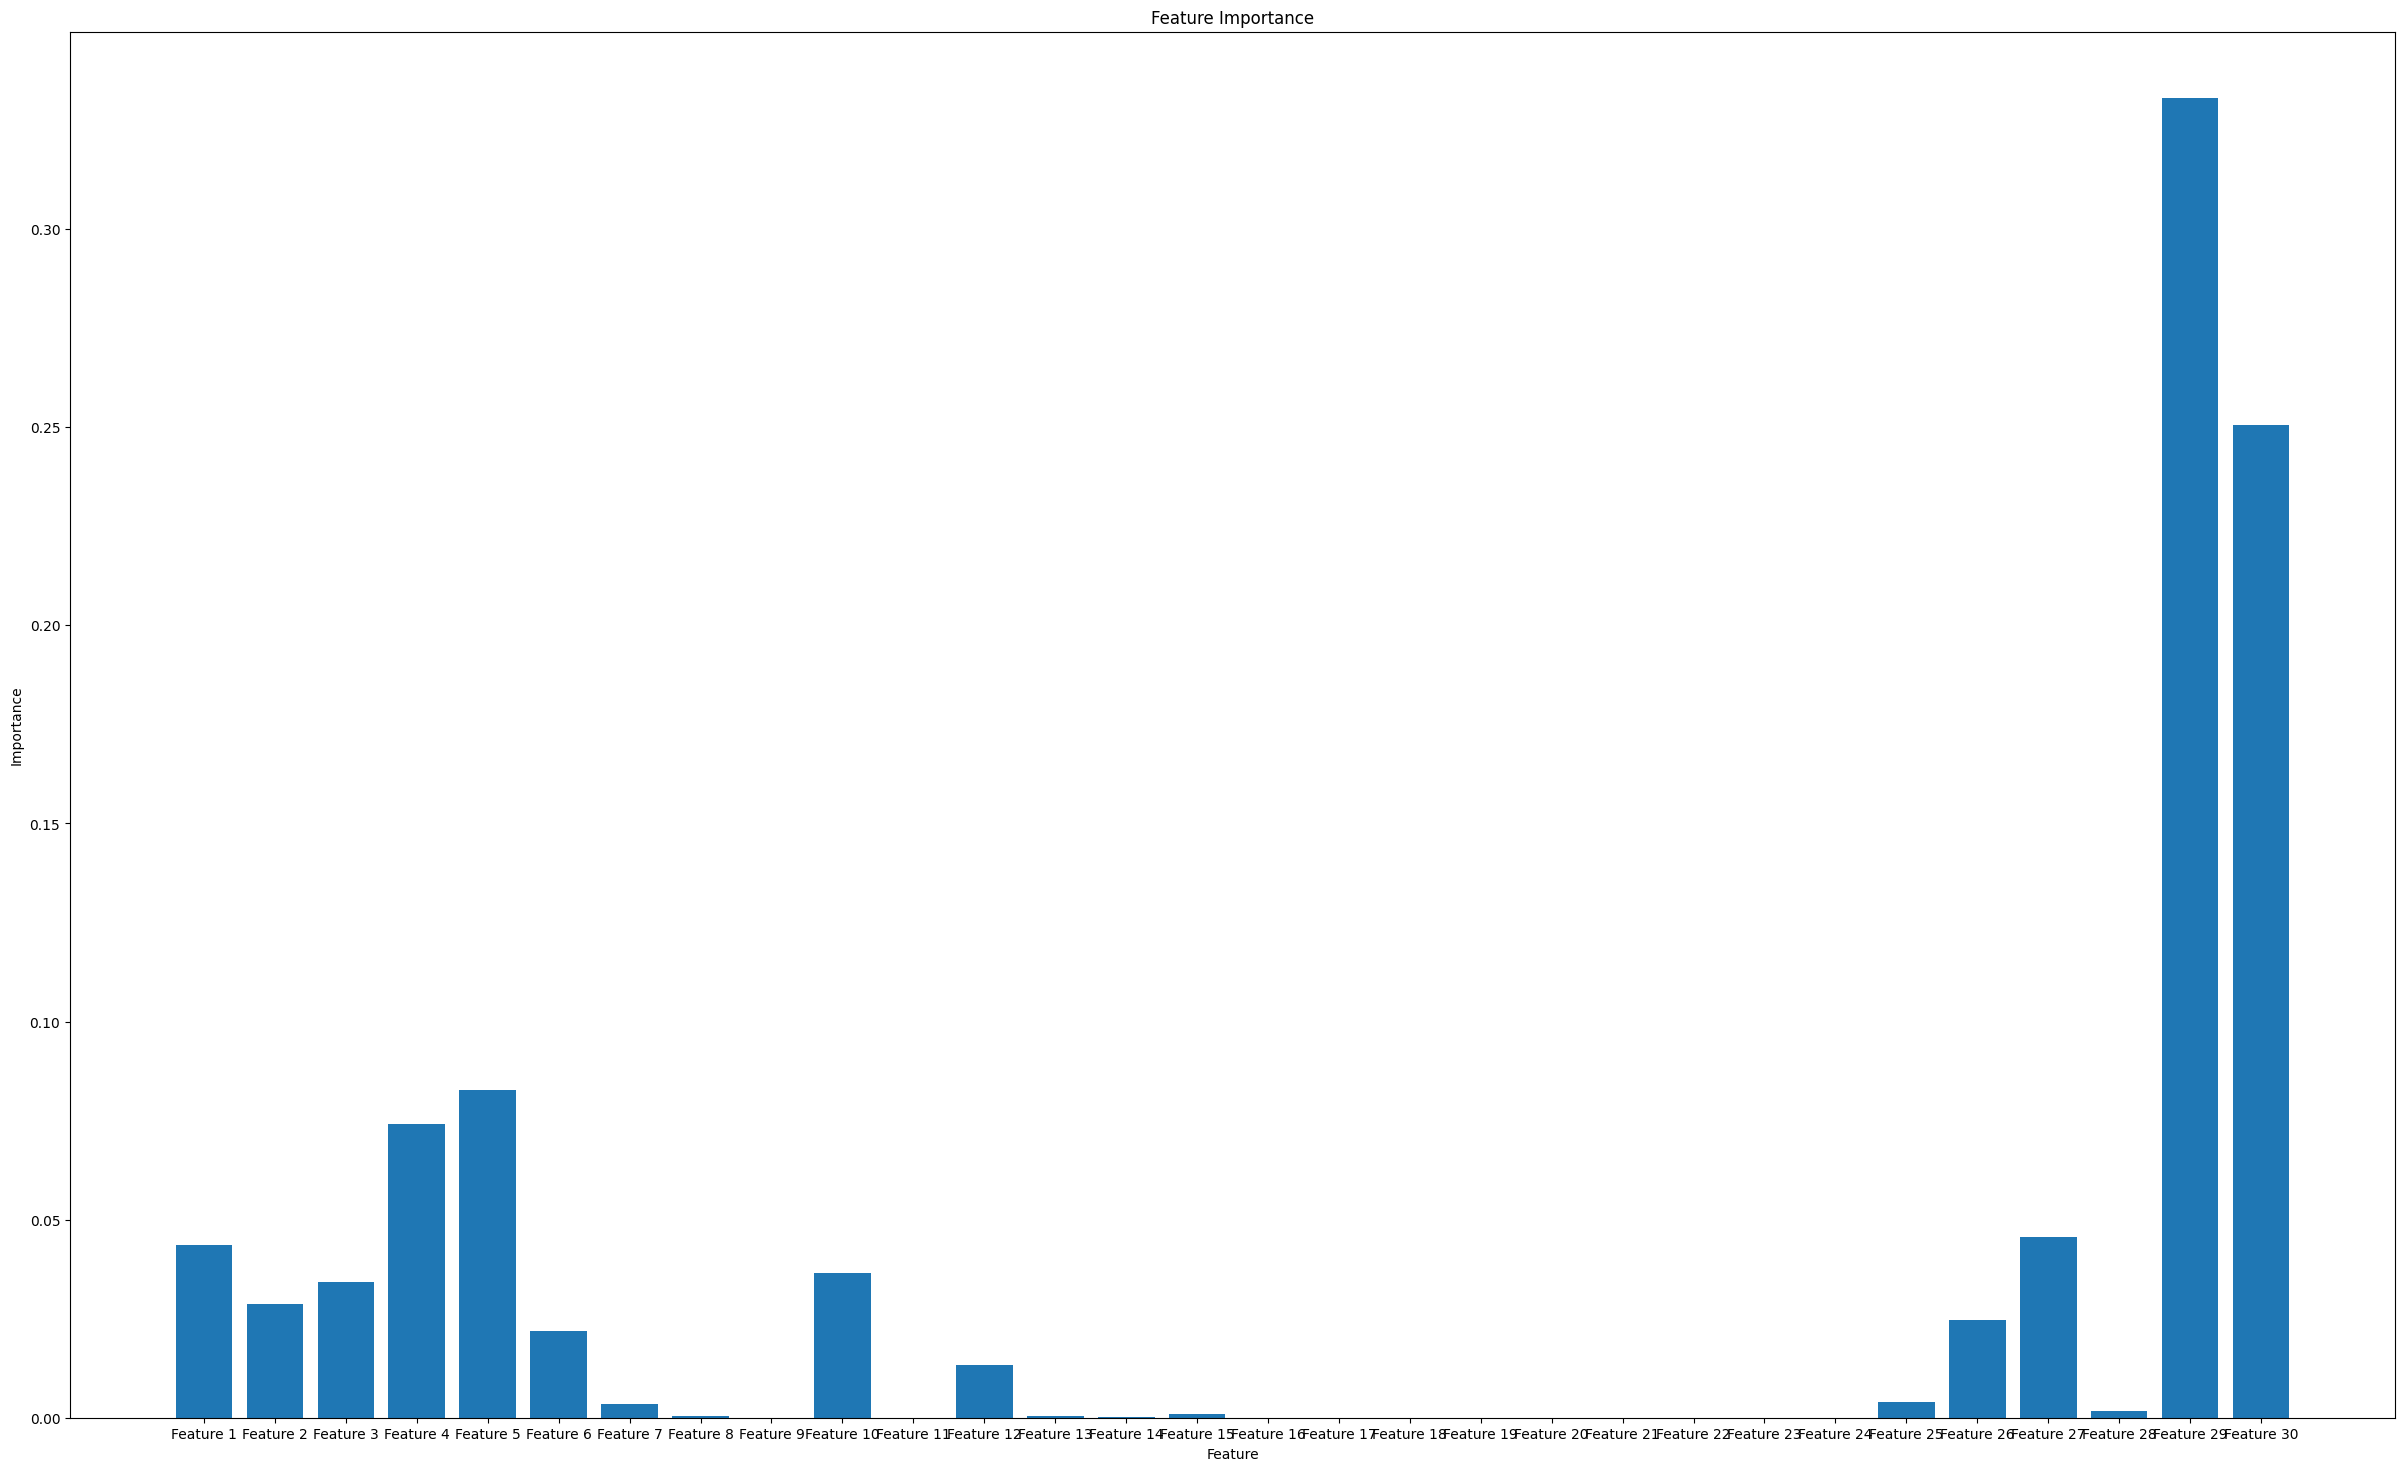

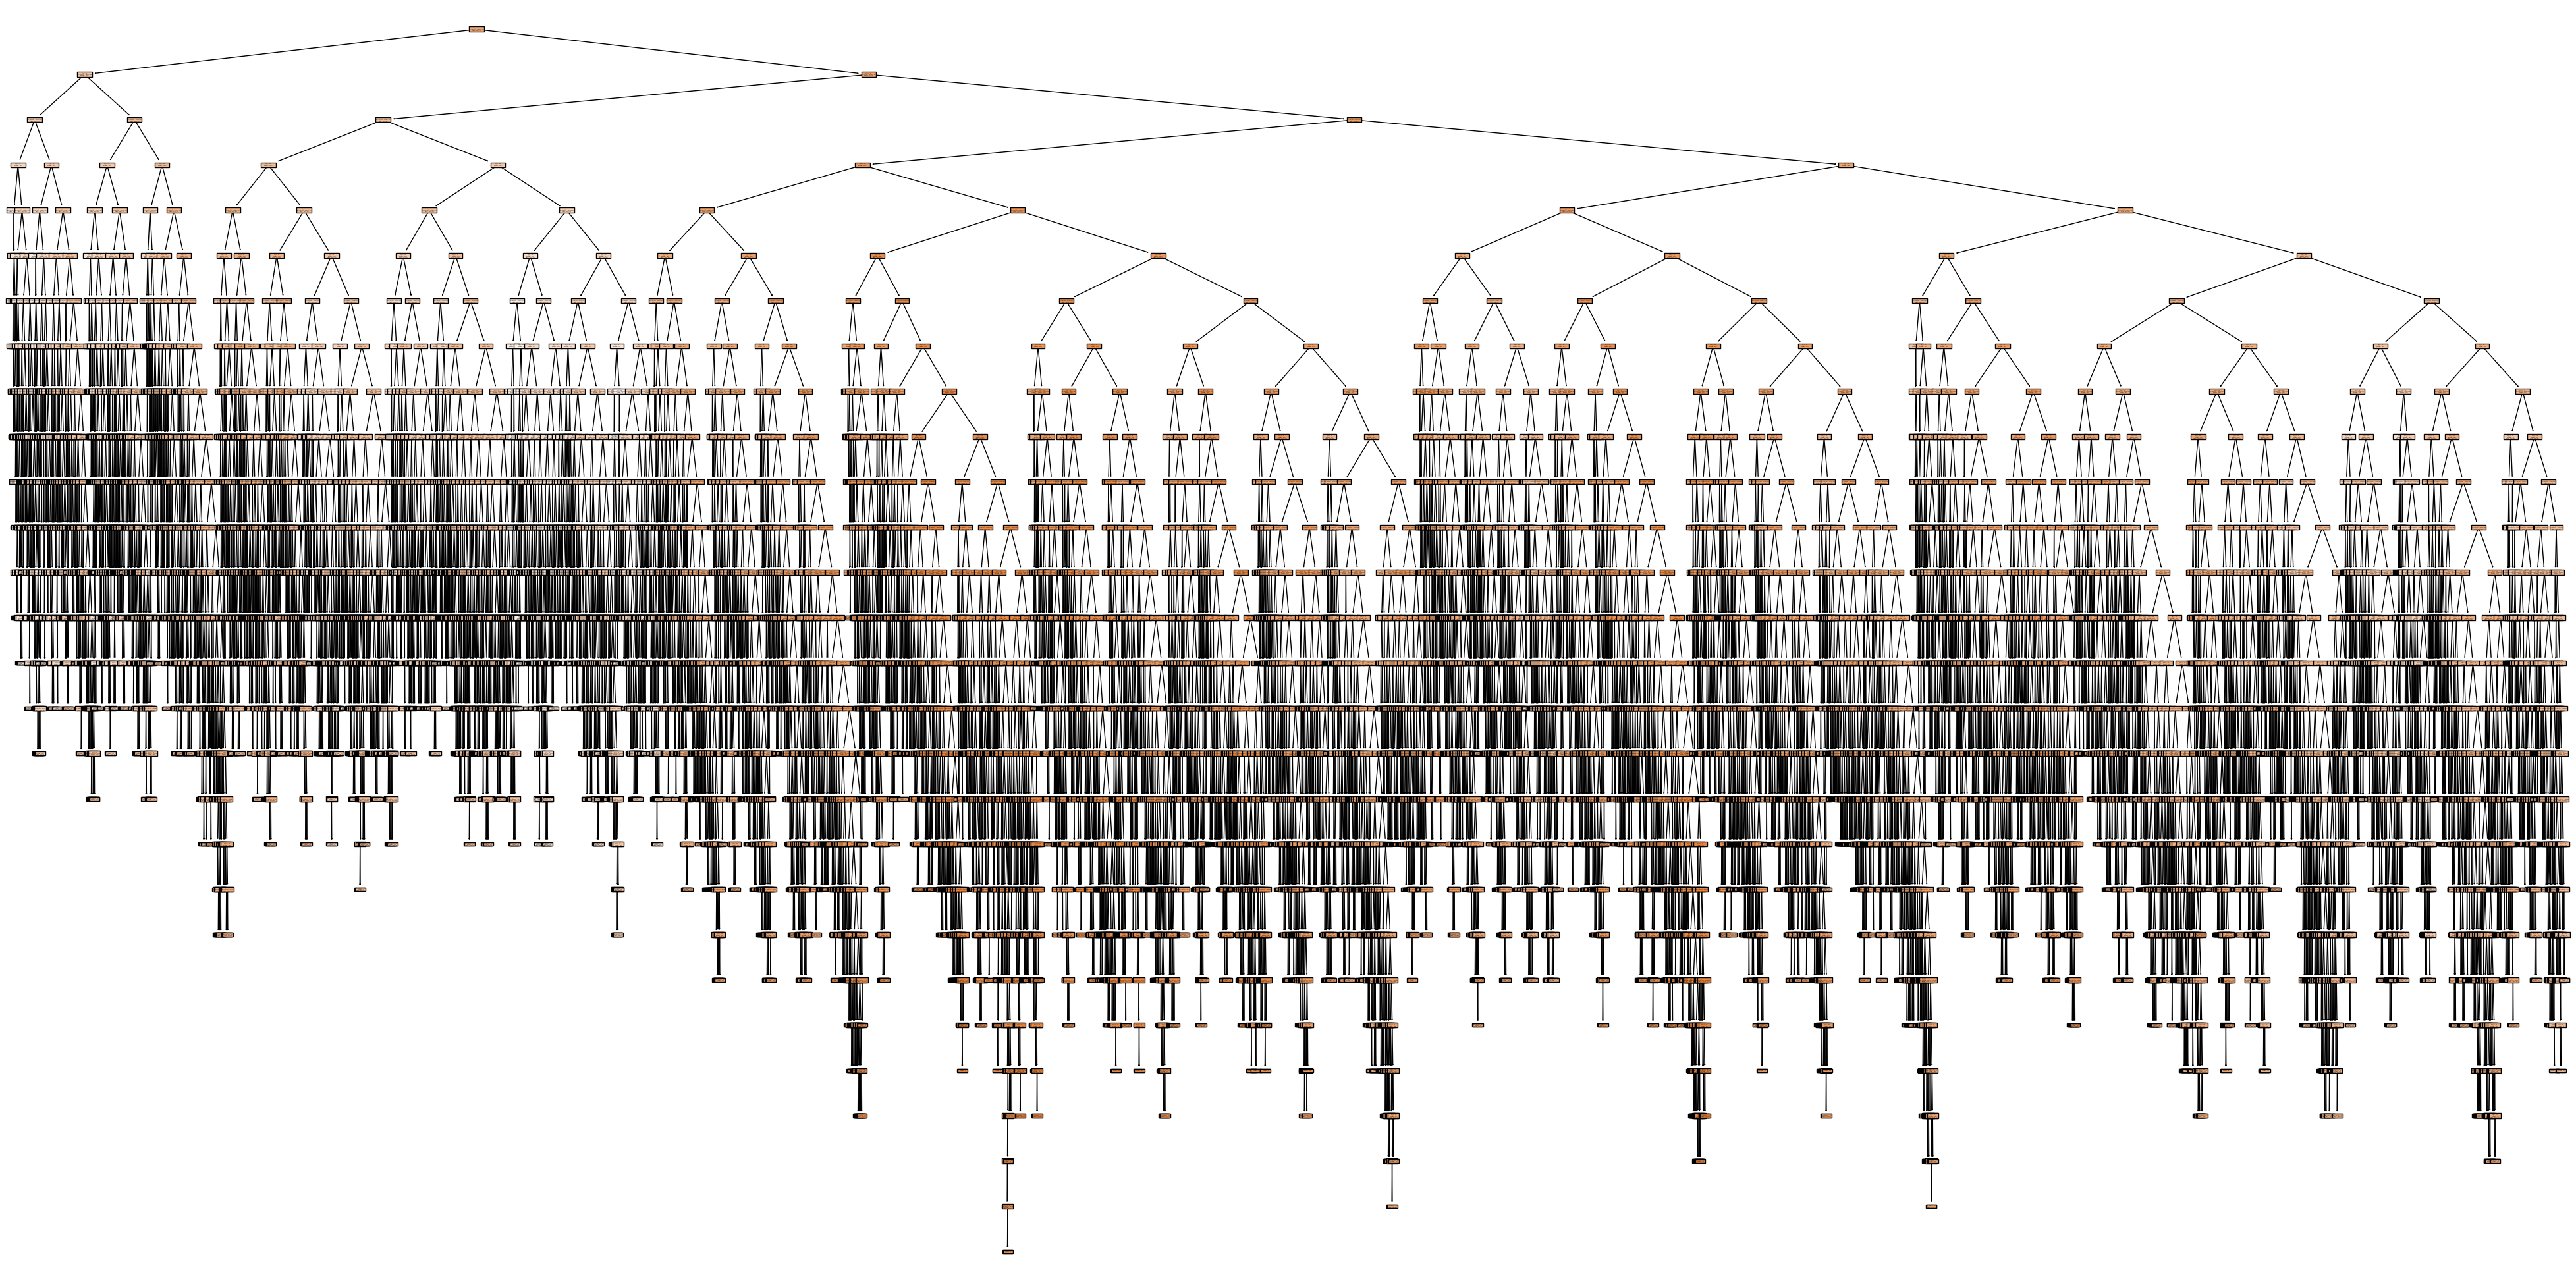

['model\\model-judgetree.pkl']

In [8]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
# 创建并训练决策树回归模型
tree_model = DecisionTreeRegressor(random_state=42)
# 执行 K 折交叉验证
cv_scores = cross_val_score(tree_model, X_train, y_train, cv=5)

# 输出每折交叉验证的评分
print("每折交叉验证的评分:", cv_scores)

# 输出交叉验证评分的平均值
print("交叉验证评分的平均值:", np.mean(cv_scores))
tree_model.fit(X_train, y_train)

# 在测试集上评估模型性能
tree_score = tree_model.score(X_test, y_test)
print("决策树模型性能评分:", tree_score)

# 输出特征重要性
feature_importances = tree_model.feature_importances_
print("特征重要性:", feature_importances)
# 将特征重要性展平
feature_importances_flat = np.ravel(feature_importances)
# 可视化特征重要性
plt.figure(figsize=(30, 18))
plt.bar(range(len(feature_importances_flat)), feature_importances_flat, tick_label=[f'Feature {i}' for i in range(1, len(feature_importances_flat) + 1)])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# 绘制决策树树状图
plt.figure(figsize=(50, 25))  # 设置图形大小
plot_tree(tree_model, filled=True)
plt.show()
# 在测试集上进行预测
y_pred = tree_model.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
# 模型存储
model_name = f"model\\model-judgetree.pkl"
# 保存模型
import joblib
joblib.dump(tree_model, model_name)

##### 梯度提升树

每折交叉验证的评分: [0.9989604  0.99872324 0.99871912 0.99863552 0.9988842 ]
交叉验证评分的平均值: 0.9987844960118896
梯度提升树模型性能评分: 0.998773850388773
特征重要性: [5.83507379e-02 3.16626492e-02 1.21197431e-02 7.53047254e-02
 7.54225974e-02 2.22281537e-02 2.71970449e-03 2.06484527e-04
 7.83651501e-05 3.22531350e-02 7.56341751e-05 1.08237777e-02
 1.81927827e-04 1.07663741e-04 6.37899272e-04 2.53757970e-06
 1.98368194e-06 1.04786591e-06 3.09376763e-08 1.39526635e-08
 9.19929212e-09 0.00000000e+00 9.10071315e-09 1.62074791e-08
 3.73904728e-02 8.21605390e-02 2.14041849e-02 3.30048266e-02
 2.84506205e-01 2.19354924e-01]


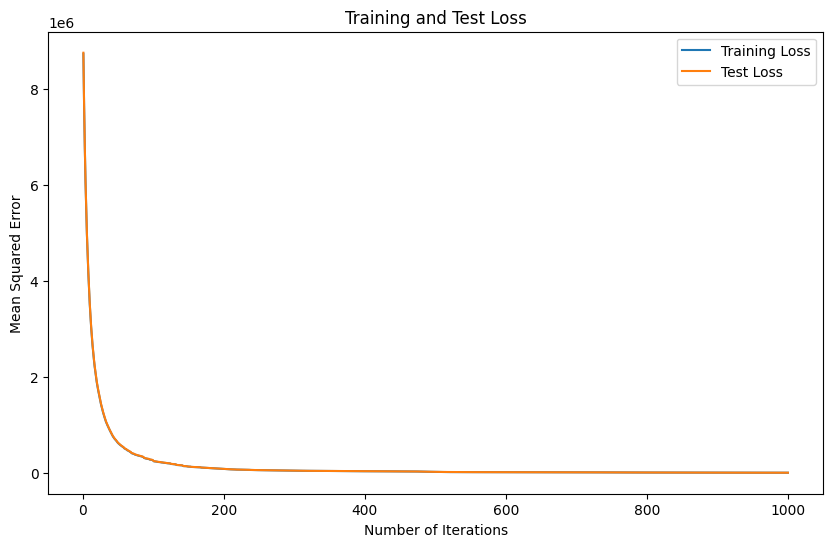

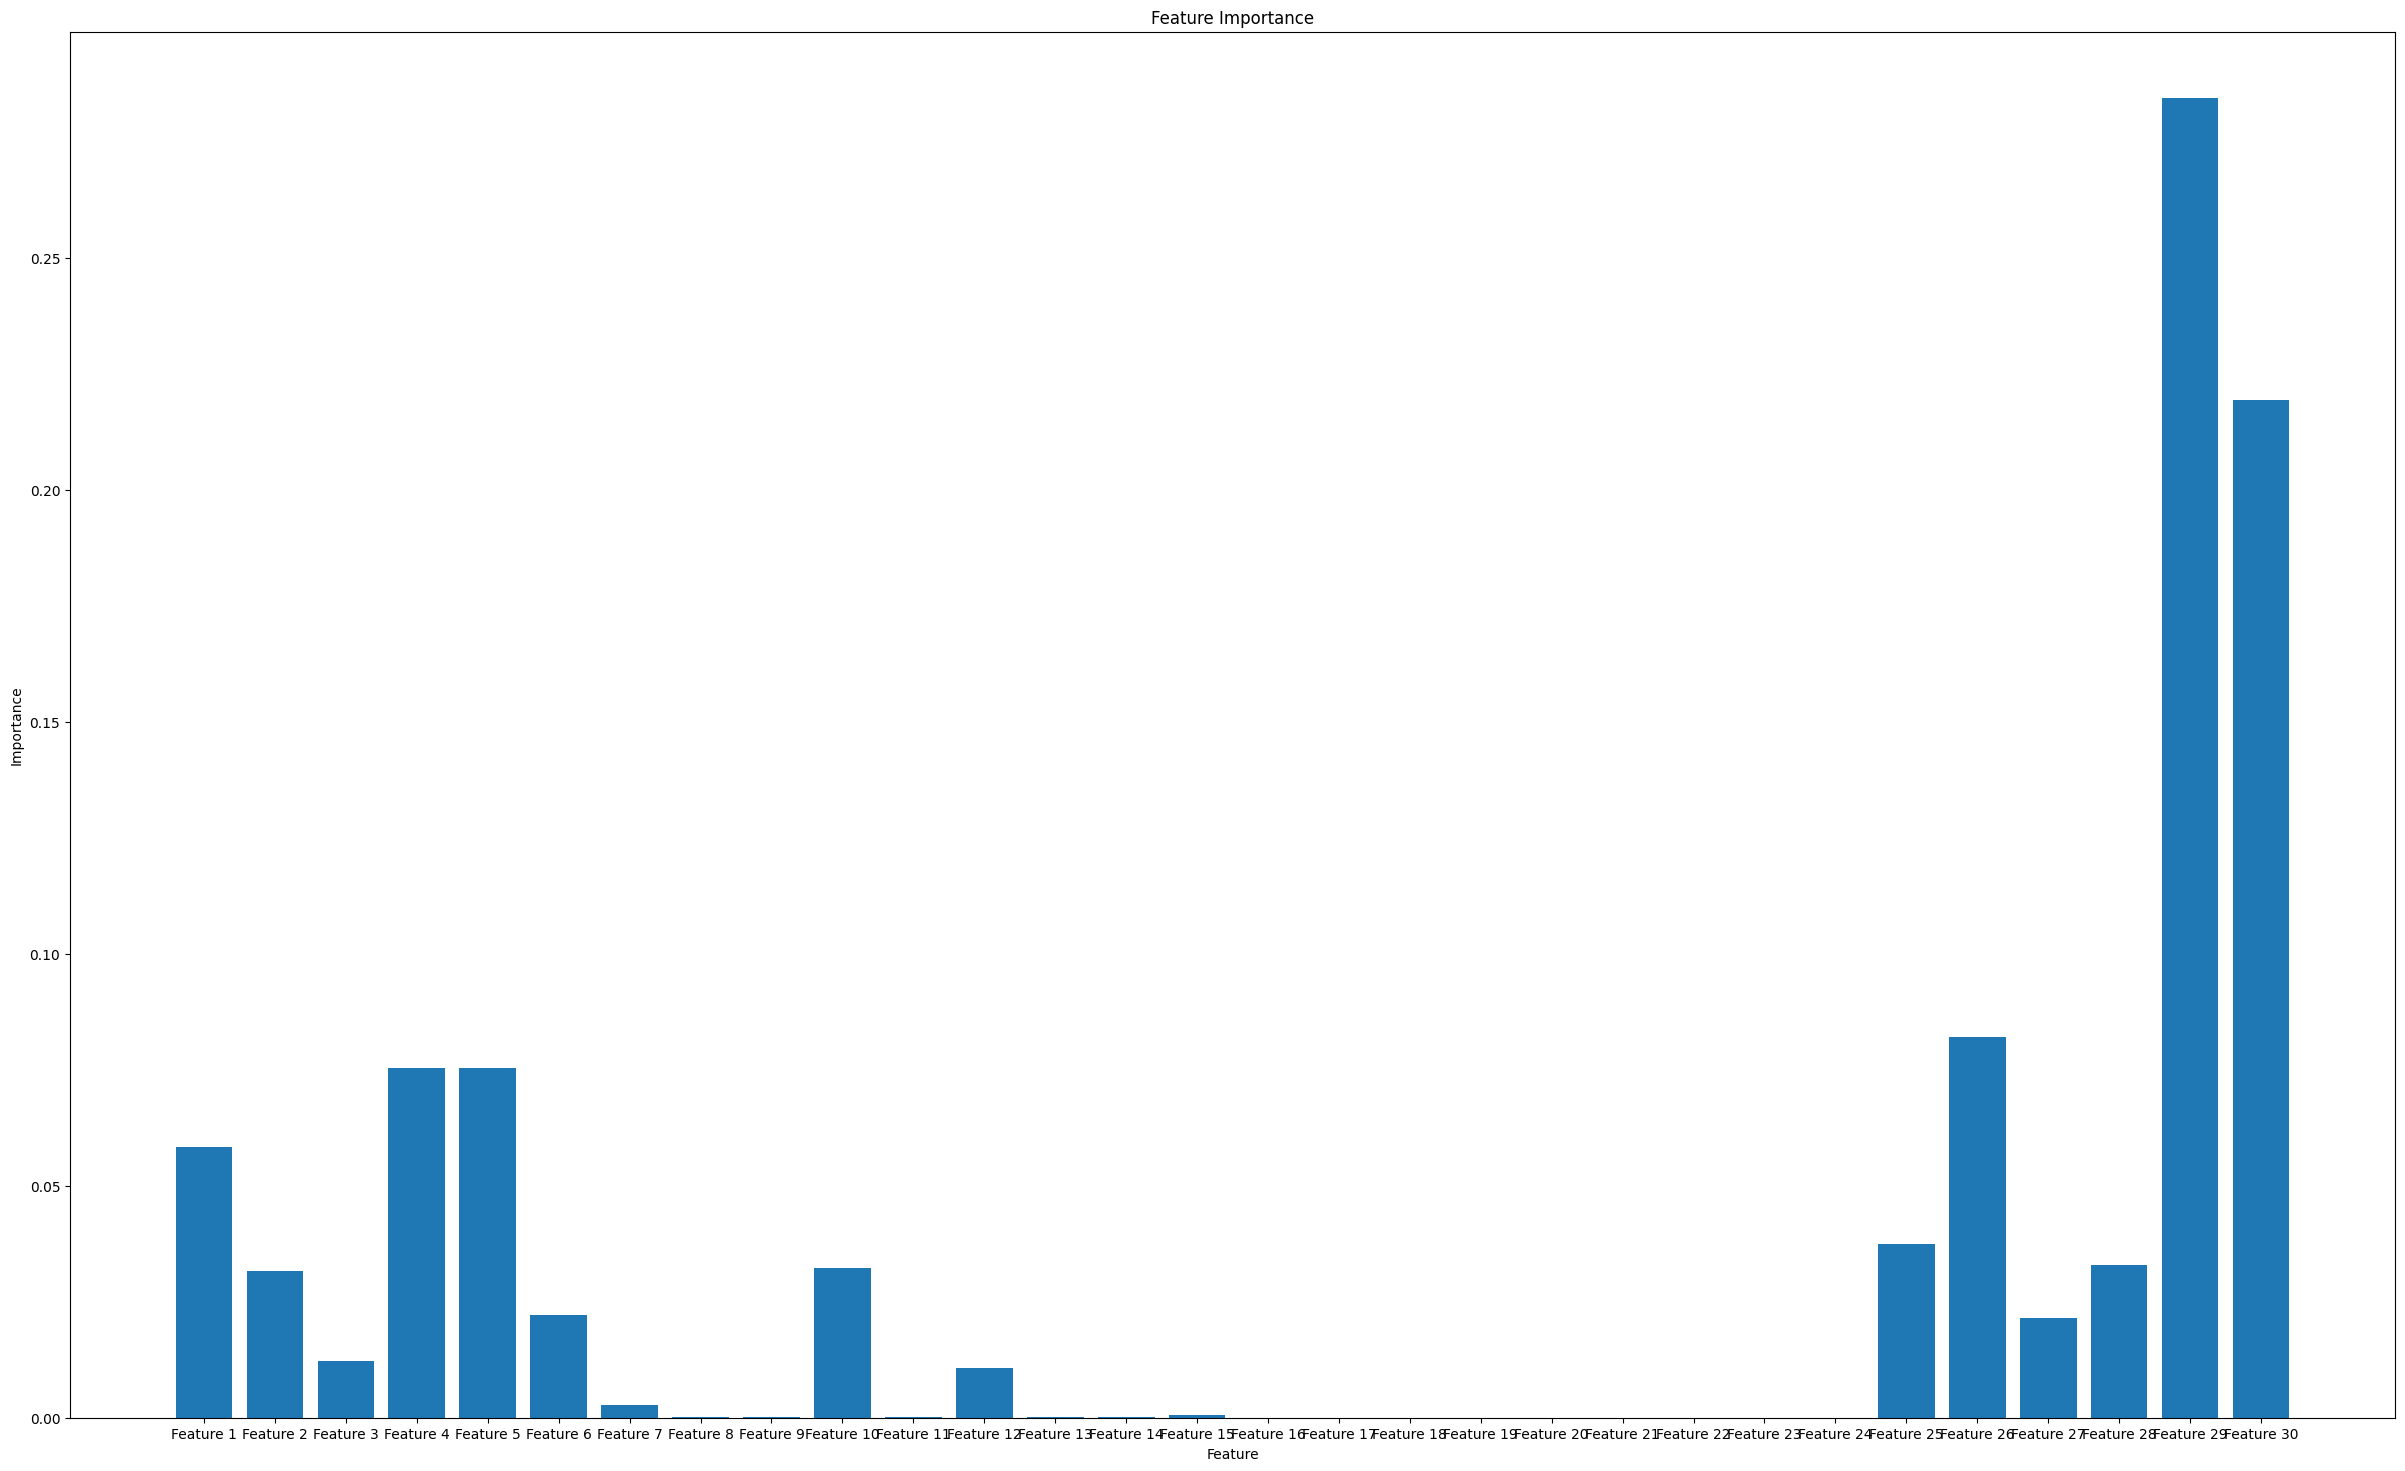

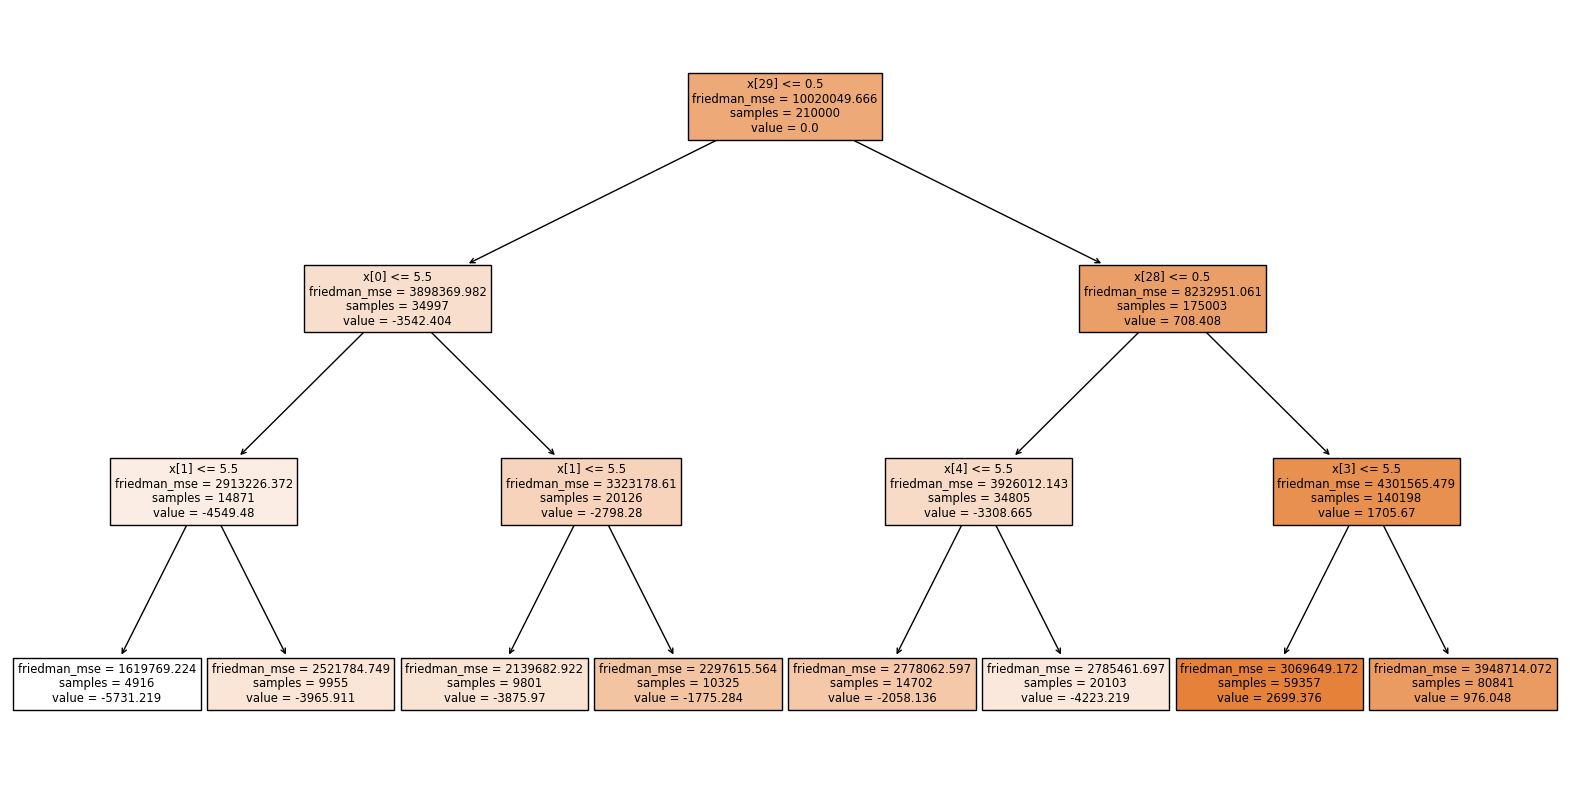

['model\\model-gbtree.pkl']

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
# 设置迭代次数为100
n_estimators = 1000

# 创建并训练梯度提升树回归模型
gb_model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=42)
# 执行 K 折交叉验证
cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5)

# 输出每折交叉验证的评分
print("每折交叉验证的评分:", cv_scores)

# 输出交叉验证评分的平均值
print("交叉验证评分的平均值:", np.mean(cv_scores))
gb_model.fit(X_train, y_train)

# 在测试集上评估模型性能
gb_score = gb_model.score(X_test, y_test)
print("梯度提升树模型性能评分:", gb_score)

# 输出特征重要性
feature_importances = gb_model.feature_importances_
print("特征重要性:", feature_importances)

# 计算每轮迭代的损失值
train_loss = np.zeros((gb_model.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(gb_model.staged_predict(X_train)):
    train_loss[i] = mean_squared_error(y_train, y_pred)

test_loss = np.zeros((gb_model.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(gb_model.staged_predict(X_test)):
    test_loss[i] = mean_squared_error(y_test, y_pred)
# 在测试集上进行预测
y_pred = gb_model.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, gb_model.n_estimators + 1), train_loss, label='Training Loss')
plt.plot(np.arange(1, gb_model.n_estimators + 1), test_loss, label='Test Loss')
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Loss')
plt.legend()
plt.show()
# 可视化特征重要性
plt.figure(figsize=(30, 18))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=[f'Feature {i}' for i in range(1, len(feature_importances) + 1)])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
# 获取第一棵决策树
first_tree = gb_model.estimators_[0, 0]  # 获取第一棵树（索引为[0, 0]）

# 绘制第一棵决策树的树状图
plt.figure(figsize=(20, 10))  # 设置图形大小
plot_tree(first_tree, filled=True)
plt.show()


# 模型存储
model_name = f"model\\model-gbtree.pkl"
# 保存模型
import joblib
joblib.dump(gb_model, model_name)


##### 线性回归

In [10]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"均方误差为: {mse}")
print(f"模型的系数为: {model.coef_}")
print(f"模型的截距为: {model.intercept_}")
# 模型存储
model_name = f"model\\model-Linear.pkl"
# 保存模型
import joblib
joblib.dump(model, model_name)


均方误差为: 1074906.508561111
模型的系数为: [ 7.63331256e+12  7.63331256e+12  7.63331256e+12  7.63331256e+12
  7.63331256e+12  7.63331256e+12  3.83484665e+14  3.83484665e+14
  3.83484665e+14  3.83484665e+14  3.83484665e+14  3.83484665e+14
 -1.44818220e+14 -1.44818220e+14 -1.44818220e+14 -1.44818220e+14
 -1.44818220e+14 -1.44818220e+14  2.53430448e+15  2.53430448e+15
  2.53430448e+15  2.53430448e+15  2.53430448e+15  2.53430448e+15
 -1.37810888e+15 -1.37810888e+15 -1.37810888e+15 -1.37810888e+15
 -1.37810888e+15 -1.37810888e+15]
模型的截距为: -2.4188457990496704e+16


['model\\model-Linear.pkl']

##### 模型性能评估

读取全部模型，构建模型列表

In [11]:
import joblib
from scipy.optimize import basinhopping
import numpy as np
model_filenames = ['model\\model-gbtree.pkl', 'model\\model-judgetree.pkl', 'model\\model-Linear.pkl']
models = [joblib.load(name) for name in model_filenames]

从全部输入中读取2000个输入，构建准确率曲线图

In [12]:
import os
import pickle
import numpy as np

def load_all_chunks(input_dir):
    all_chunks = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.pkl'):
            filepath = os.path.join(input_dir, filename)
            with open(filepath, 'rb') as f:
                chunk = pickle.load(f)
            all_chunks.append(chunk)
    merged_data = np.concatenate(all_chunks, axis=0)
    return merged_data
input_directory = "distributed_storage"
FIX_ALL_ANSWER = load_all_chunks(input_directory)

In [13]:
print(FIX_ALL_ANSWER.shape)
FIX_ALL_ANSWER=FIX_ALL_ANSWER.reshape(10077696,30)
print(FIX_ALL_ANSWER[0])

(10077696, 5, 6)
[3 6 6 6 6 6 1 3 3 3 3 3 2 4 4 4 4 4 1 2 2 2 2 2 0 1 1 1 1 1]


随机选取2000个输入作为验证

In [14]:
Input_Example=[]
for i in range(1):
    np.random.shuffle(FIX_ALL_ANSWER)

In [15]:
for i in range(2000):
    Input_Example.append(FIX_ALL_ANSWER[i])

In [16]:
print(Input_Example)

[array([6, 6, 5, 6, 5, 5, 3, 3, 3, 2, 2, 3, 4, 4, 2, 4, 4, 4, 2, 2, 2, 2,
       2, 1, 0, 1, 1, 1, 1, 1]), array([6, 6, 6, 6, 4, 5, 2, 3, 3, 3, 3, 2, 4, 3, 4, 3, 4, 4, 2, 1, 2, 2,
       2, 2, 1, 1, 1, 0, 1, 1]), array([6, 6, 6, 5, 5, 5, 3, 3, 3, 3, 1, 3, 4, 3, 3, 4, 4, 4, 2, 2, 2, 2,
       1, 2, 1, 1, 0, 1, 1, 1]), array([6, 5, 6, 5, 6, 5, 3, 3, 3, 2, 3, 2, 4, 4, 3, 4, 3, 4, 2, 2, 2, 2,
       1, 2, 1, 1, 1, 1, 1, 0]), array([6, 6, 6, 5, 5, 5, 3, 3, 3, 3, 1, 3, 4, 3, 4, 4, 3, 4, 2, 2, 2, 1,
       2, 2, 1, 0, 1, 1, 1, 1]), array([6, 5, 6, 5, 5, 6, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 0, 1, 1, 1]), array([5, 5, 6, 6, 5, 6, 3, 3, 3, 3, 2, 2, 4, 4, 3, 3, 4, 4, 2, 2, 2, 2,
       1, 2, 1, 1, 1, 0, 1, 1]), array([6, 6, 5, 6, 5, 5, 2, 3, 2, 3, 3, 3, 4, 3, 4, 3, 4, 4, 2, 1, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 0]), array([5, 6, 5, 6, 5, 6, 2, 3, 3, 3, 2, 3, 3, 3, 4, 4, 4, 4, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 0]), array([6, 6, 6, 3, 6, 6, 2, 3, 3, 3, 2, 3, 4,

用准确率衡量模型的准确率

C:\Users\12780\AppData\Roaming\Python\Python39\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


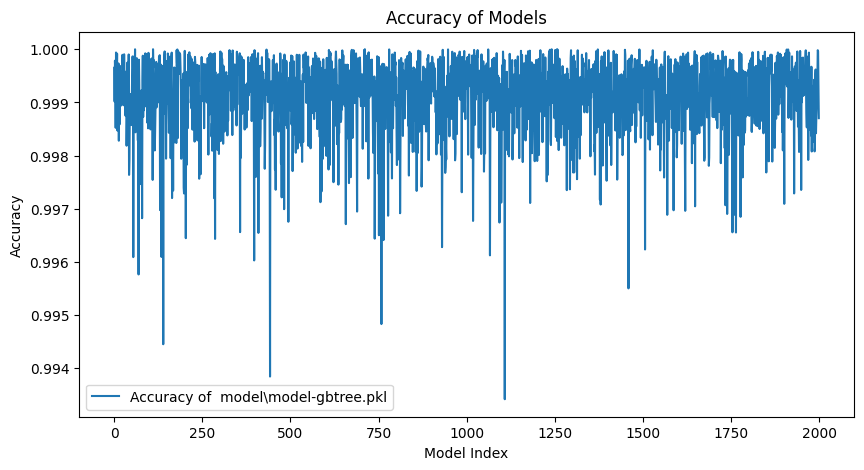

C:\Users\12780\AppData\Roaming\Python\Python39\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


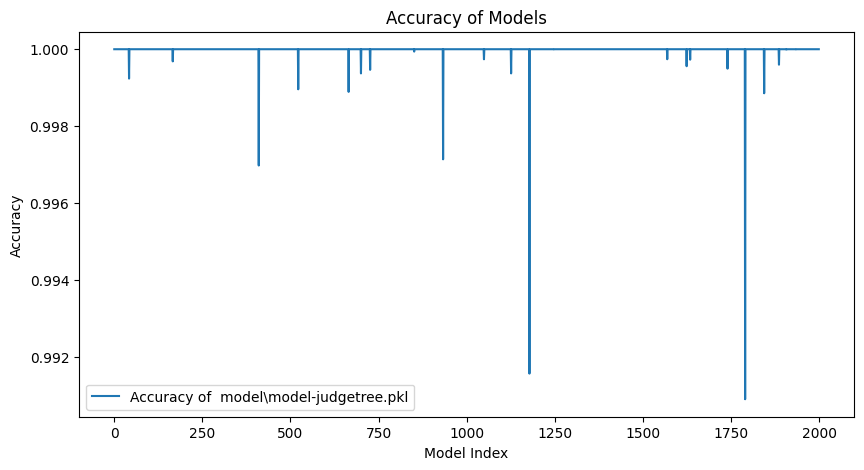

C:\Users\12780\AppData\Roaming\Python\Python39\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


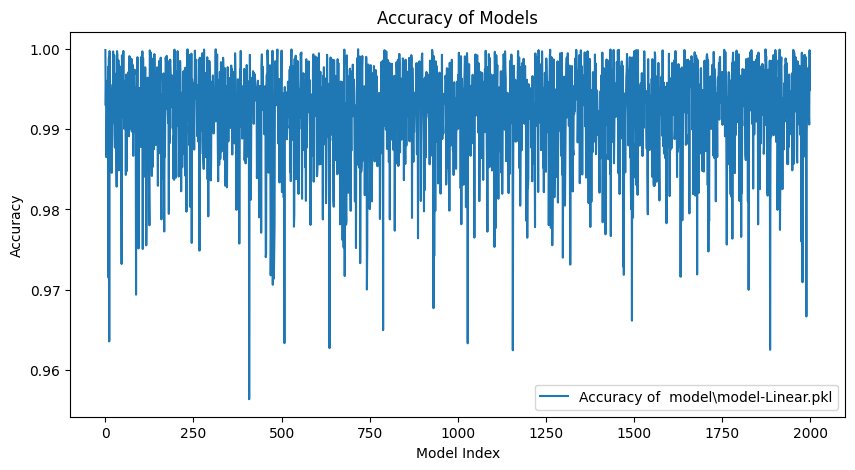

In [17]:
import matplotlib.pyplot as plt
def transpose_list(matrix):
    if not matrix:
        return []
    
    rows = len(matrix)
    cols = len(matrix[0])
    
    transposed_matrix = []
    for j in range(cols):
        transposed_row = []
        for i in range(rows):
            transposed_row.append(matrix[i][j])
        transposed_matrix.append(transposed_row)
    return transposed_matrix
def calculate_accuracy(y_true, y_pred):
    mse=[]
    for i in range(len(y_true)):
        mse.append(min(y_true[i],y_pred[i])/max(y_true[i],y_pred[i]))
    return mse
from core import LinearProblem
for i in range(len(models)):
    Input_Example=np.array(Input_Example)
    now_model=models[i]
    Answer_predict=[]
    if i!=3:
        Answer_predict=now_model.predict(Input_Example)
    else:
        constant_value = -3.148e+10
        constant_column = np.full((Input_Example.shape[0], 1), constant_value)
        # 垂直堆叠X和constant_column，得到新的输入数组
        Input_Example1 = np.concatenate((Input_Example, constant_column), axis=1)
        Answer_predict=now_model.predict(Input_Example1)
    problem=LinearProblem.LinearCore()
    Answer_exact=[]
    for j in range(2000):
        temp=Input_Example[j].reshape(5,6).tolist()
        temp=transpose_list(temp)
        problem.reset_machine(transpose_list(Input_Example[j].reshape(5,6).tolist()))
        Answer_exact.append(problem.solveP())
    Answer_exact=np.array(Answer_exact)
    # 计算准确率（这里使用MSE作为准确率的衡量标准）
    accuracy = calculate_accuracy(Answer_exact, Answer_predict)
    # 绘制准确率曲线
    plt.figure(figsize=(10, 5))
    plt.plot(accuracy, label=f'Accuracy of  {model_filenames[i]}')
    plt.xlabel('Model Index')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy of Models')
    plt.legend()
    plt.show()



### 用不同的模型求解本问题

In [18]:
max_fit=0
max_array=[]

In [19]:
import os
import pickle
import numpy as np

def load_all_chunks(input_dir):
    all_chunks = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.pkl'):
            filepath = os.path.join(input_dir, filename)
            with open(filepath, 'rb') as f:
                chunk = pickle.load(f)
            all_chunks.append(chunk)
    merged_data = np.concatenate(all_chunks, axis=0)
    return merged_data
input_directory = "distributed_storage"
DATA = load_all_chunks(input_directory)
DATA=DATA.reshape(-1,30)

In [20]:
print(DATA[0])

[3 6 6 6 6 6 1 3 3 3 3 3 2 4 4 4 4 4 1 2 2 2 2 2 0 1 1 1 1 1]


用不同的模型进行预测

In [21]:
def transpose_list(matrix):
    if not matrix:
        return []
    
    rows = len(matrix)
    cols = len(matrix[0])
    
    transposed_matrix = []
    for j in range(cols):
        transposed_row = []
        for i in range(rows):
            transposed_row.append(matrix[i][j])
        transposed_matrix.append(transposed_row)
    return transposed_matrix
from core import LinearProblem
problem=LinearProblem.LinearCore()
for i in range(len(models)):
    model=models[i]
    PRE=model.predict(DATA)
    temp=np.unravel_index(np.argmax(PRE), PRE.shape)
    problem.reset_machine(transpose_list(DATA[temp].reshape(5,6).tolist()))
    print(temp,DATA[temp],PRE[temp],problem.solveP())

C:\Users\12780\AppData\Roaming\Python\Python39\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


(4593261,) [6 6 6 4 5 6 3 3 3 1 3 3 4 4 4 2 4 4 2 1 2 2 2 2 1 1 1 0 1 1] 105441.82434683102 104728.0


C:\Users\12780\AppData\Roaming\Python\Python39\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


(4566615,) [6 6 6 4 5 6 2 2 3 3 3 3 3 3 4 4 4 4 1 2 2 2 2 2 1 1 1 0 1 1] 105007.5 105007.5
(4537543,) [6 6 6 3 6 6 3 3 1 3 3 3 4 4 4 2 4 4 2 2 2 1 2 2 1 0 1 1 1 1] 106000.0 104070.0


C:\Users\12780\AppData\Roaming\Python\Python39\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


以上输出为最终预测结果，最后一项为预测的最大机器排布的实际最大利润

[6 6 6 4 5 6 2 4 4 4 4 4 3 3 3 1 3 3 1 2 2 2 2 2 1 1 1 0 1 1] 104981.0 为最终预测答案